In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import tensorflow.contrib.distributions as ds

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [4]:
eps = 1e-10

In [5]:
def generator(noise_in, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        lay = layers.relu(noise_in, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)

    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)

    return outputs, these_vars

In [6]:
def EM_network(data, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):       
        lay = layers.relu(data, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [7]:
def make_EM_loss(data_P, data_Q, name):
    local_EM_network_name = name + "_EM_net"
    
    # generator output
    T_P, EM_vars = EM_network(data_P, name = local_EM_network_name)
    
    # target
    T_Q, _ = EM_network(data_Q, name = local_EM_network_name)

    EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
    
    batch_size_dyn = tf.cast(tf.shape(T_P)[0], tf.int32)
    rand = tf.random.uniform(shape = (batch_size_dyn, 1), minval = 0.0, maxval = 1.0)
    
    # add gradient penalty
    x_grad = tf.math.add(tf.math.multiply(rand, data_P),
                         tf.math.multiply(tf.math.subtract(1.0, rand), data_Q))
    x_grad_EM, _ = EM_network(x_grad, name = local_EM_network_name)
    grad = tf.gradients(x_grad_EM, x_grad)[0]
    
    grad_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(grad), axis = 1) + eps)
    
    grad_pen = tf.reduce_mean(tf.math.square(grad_norm - 1.0))

    EM_loss_grad_pen = EM_loss[0] + 10 * grad_pen

    return EM_loss_grad_pen, EM_vars, -EM_loss

In [8]:
def save_plots(file_path):
    # compare initial distributions
    target_test = np.random.normal(loc = 1, scale = 1, size = (10000, 1))
    noise_test = np.random.uniform(low = 0.0, high = 1.0, size = (10000, 20))
    gen_output_test = sess.run(gen_out,  feed_dict = {noise_in: noise_test})
    
    plt.clf()
    plt.hist([np.squeeze(target_test), np.squeeze(gen_output_test)], label = ['target', 'generator'], histtype = 'step', density = True, bins = 50)
    plt.legend()
    plt.savefig(file_path)

In [9]:
targetdist = ds.Normal(loc = 1.0, scale = 1.0)

In [10]:
noise_in = tf.placeholder(tf.float32, [None, 20], name = 'noise_in')
target_in = tf.placeholder(tf.float32, [None, 1], name = 'target_in')

In [11]:
gen_out, gen_vars = generator(noise_in, "gen")

In [12]:
EM_lossval, EM_vars, EM_dist = make_EM_loss(gen_out, target_in, "EM_loss_obj")

In [13]:
train_EM = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999).minimize(EM_lossval, var_list = EM_vars)

In [14]:
train_gen = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.5, beta2 = 0.9).minimize(EM_dist, var_list = gen_vars)

In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
init_critic = tf.variables_initializer(EM_vars)

In [17]:
sess.run(init_critic)

In [18]:
# prepare noise
for i in range(20):
    target = np.random.normal(loc = 1, scale = 1, size = (1000, 1))
    noise = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 20))
    sess.run(train_EM, feed_dict = {noise_in: noise, target_in: target})

    EM_dist_val = sess.run(EM_dist, feed_dict = {noise_in: noise, target_in: target})
    print("EM_dist = {}".format(EM_dist_val))

EM_dist = [0.12961727]
EM_dist = [0.18099904]
EM_dist = [0.22931308]
EM_dist = [0.2850085]
EM_dist = [0.3311053]
EM_dist = [0.41057247]
EM_dist = [0.45066965]
EM_dist = [0.48801452]
EM_dist = [0.5786333]
EM_dist = [0.5159638]
EM_dist = [0.5976347]
EM_dist = [0.55022395]
EM_dist = [0.59010696]
EM_dist = [0.5154965]
EM_dist = [0.5566251]
EM_dist = [0.5169923]
EM_dist = [0.49784794]
EM_dist = [0.5186688]
EM_dist = [0.5406487]
EM_dist = [0.52607137]


In [19]:
# compare initial distributions
target_test = np.random.normal(loc = 1, scale = 1, size = (1000, 1))
noise_test = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 20))
gen_output_test = sess.run(gen_out,  feed_dict = {noise_in: noise_test})

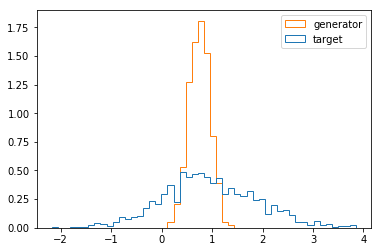

In [20]:
plt.hist([np.squeeze(target_test), np.squeeze(gen_output_test)], label = ['target', 'generator'], histtype = 'step', density = True, bins = 50)
plt.legend()
plt.show()

In [21]:
for i in range(500):
    # prepare noise
    for j in range(100):
        target = np.random.normal(loc = 1, scale = 1, size = (1000, 1))
        noise = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 20))
        sess.run(train_EM, feed_dict = {noise_in: noise, target_in: target})
    
    target = np.random.normal(loc = 1, scale = 1, size = (1000, 1))
    noise = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 20))
    sess.run(train_gen, feed_dict = {noise_in: noise, target_in: target})
    EM_dist_val = sess.run(EM_dist, feed_dict = {noise_in: noise, target_in: target})
    critic_loss = sess.run(EM_lossval, feed_dict = {noise_in: noise, target_in: target})
    
    print("W = {}".format(EM_dist_val))
    print("critic loss = {}".format(critic_loss))
    
    save_plots("WGAN_training/epoch_" + str(i).zfill(5) + ".png")

W = [0.7058315]
critic loss = -0.5456446409225464
W = [0.69634193]
critic loss = -0.6363821625709534
W = [0.68290395]
critic loss = -0.6563143730163574
W = [0.67414266]
critic loss = -0.6317578554153442
W = [0.66833603]
critic loss = -0.6481044888496399
W = [0.70782053]
critic loss = -0.6896194815635681
W = [0.6591779]
critic loss = -0.645799458026886
W = [0.6815162]
critic loss = -0.6253578066825867
W = [0.68940145]
critic loss = -0.6756784319877625
W = [0.69454587]
critic loss = -0.6813023686408997
W = [0.66678065]
critic loss = -0.6478521227836609
W = [0.65558684]
critic loss = -0.6434328556060791
W = [0.6693979]
critic loss = -0.6550666093826294
W = [0.6096315]
critic loss = -0.5980310440063477
W = [0.6514359]
critic loss = -0.6366586685180664
W = [0.6638937]
critic loss = -0.5915642976760864
W = [0.6716049]
critic loss = -0.652596116065979
W = [0.6690169]
critic loss = -0.6567921042442322
W = [0.62897474]
critic loss = -0.6215819120407104
W = [0.6394346]
critic loss = -0.630381762